In [1]:
import os, pathlib, shutil
from collections import Counter
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import v2
import torch.nn as nn
import numpy as np
import torch
from torch.profiler import profile, record_function, ProfilerActivity
import train
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder

src = ""
if os.name == "nt":
    src = "D:/599DL4VProject/the_wildfire_dataset"
elif os.name == "posix":
    src = "/home/asromelo/Desktop/Projects/599_proj/the_wildfire_dataset/"

wf1TrainPath = pathlib.Path(src + '/train').resolve()
wf1ValidPath = pathlib.Path(src + '/valid').resolve()
wf1TestPath = pathlib.Path(src + '/test').resolve()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.jit.onednn_fusion_enabled = True
torch.manual_seed(42)


# Currently using Kaggle The Wildfire Dataset and FiSmo dataset
# https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images
# https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset

# References
# AE: http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/
# VAE: https://arxiv.org/pdf/1606.05908.pdf
# ACAI: https://arxiv.org/pdf/1807.07543.pdf

c:\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Python311\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorc

In [ ]:
from torchvision.utils import save_image
# Run this once to pre-format the data for faster training

boost = v2.Compose([
    v2.ToImageTensor(),
    v2.ConvertImageDtype(torch.uint8),
    v2.Resize(size=720, max_size=1280, interpolation=InterpolationMode.BICUBIC, antialias=True),
    v2.ConvertImageDtype(dtype=torch.float)
])
preprocess = ImageFolder(root=str(wf1TrainPath), transform=boost)

for idx, (data, target) in enumerate(preprocess):
    fname, label = preprocess.imgs[idx]
    if label == 1:
        save_image(data, fname)

/nix/store/k7xkpa8lwkjanf79r0fj3bhviv4vqm8q-python3-3.10.13-env/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/nix/store/k7xkpa8lwkjanf79r0fj3bhviv4vqm8q-python3-3.10.13-env/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [2]:
# Next W = (W + 2*pad - Kernel)/stride + 1
def downlayer(w,k,p,s):
    a1 = conv(w,k,p,s)
    a2 = conv(a1,k,p,s)
    return conv(a2,k,0,2)

def conv(w,k,p,s):
    return (w + 2*p - k)/s + 1

def convBlock(w,ksp:(int,int,int)):
    return (w + 2*ksp[2] - ksp[0])/ksp[1] + 1

def upBlock(w,ksp:(int,int,int),pad=0):
    u = 2*(w-1) - 2*pad + 1*(2-1) + 0 + 1
    return convBlock(u,ksp)

def unpooled(w,k,p,s):
    h = (w + 2*p - k)/s + 1
    return (h + 2*p - k)/s + 1

def backward(w,k,p,s):
    f = 2*(w - 1) + 2 - 2*p
    g = s*(f - 1) + k - 2*p
    return s*(g - 1) + k - 2*p

def uplayer(w,k,p,s,inner=0):
    d = 1
    innerkernel = 2
    innerstride = 2
    outpad = 0
    # Formula for Conv = (H_in - 1)*stride - 2*p + dilation*(k-1) + outpad + 1
    u = innerstride*(w - 1) - 2*inner + d*(innerkernel-1) + outpad + 1
    a1 = conv(u,k,p,s)
    return a1
    # 148 -> 72 -> 34 -> 30

def upconv(w,k,p,s):
    return s*(w-1) - 2*p + 1*(k-1) + 0 + 1

w=129
ksp = (4,1,0)

e1 = convBlock(w,ksp)
e2 = convBlock(e1,(4,2,0))
e3 = convBlock(e2,(4,2,0))
e4 = convBlock(e3,(4,2,0))
bot = convBlock(e4,ksp)
d1 = upBlock(bot,ksp)
d2 = upBlock(d1,ksp)
d3 = upBlock(d2,ksp)
d4 = upBlock(d3,ksp,1)
print("output size: ", conv(d4,1,0,1))
img_size = int(d4)
(e1,e2,e3,e4,bot,d1,d2,d3,d4)

output size:  129.0


(126.0, 62.0, 30.0, 14.0, 11.0, 19.0, 35.0, 67.0, 129.0)

Random Idea: What if we train and evaluate using batch of very small random crops (64x64) for each image then adjust loss via bayesian or expected value? Actual set of feature needed to classify a sample can be surprisingly small.

In [3]:
p = 0.2
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_size = 128

tfset = v2.Compose([
        v2.ToImageTensor(),
        v2.ConvertImageDtype(torch.uint8),
        v2.RandomCrop(size=512, pad_if_needed=True, padding_mode='edge'),
        v2.RandomChoice(transforms=[
            v2.Grayscale(3),
            v2.RandomRotation(45),
            v2.RandomEqualize(p),
        ], p=[0.3,0.3,0.3]),
        v2.RandomHorizontalFlip(p),
        v2.Resize(size=img_size, antialias=False),
        v2.ConvertImageDtype(dtype=torch.float),
])

testset = v2.Compose([
    v2.ToImageTensor(),
    v2.ConvertImageDtype(torch.uint8),
    v2.Resize(size=720, interpolation=InterpolationMode.BICUBIC, antialias=True),
    v2.CenterCrop(size=512),
    v2.Resize(size=img_size, antialias=False),
    v2.ConvertImageDtype(dtype=torch.float),
])

wf1Train = train.ForestFireDataset(root=str(wf1TrainPath), transform=tfset)
wf1Valid = train.ForestFireDataset(root=str(wf1ValidPath), transform=testset)
wf1Test = train.ForestFireDataset(root=str(wf1TestPath), transform=testset)

wf1Tsfire = Subset(wf1Test, [i for i, label in enumerate(wf1Test.targets) if label == 0])
wf1Tsnofire = Subset(wf1Test, [i for i, label in enumerate(wf1Test.targets) if label == 1])
wf1nofire = Subset(wf1Train, [i for i, label in enumerate(wf1Train.targets) if label == 1])

batch_size = 12
wf1TrLoader = DataLoader(dataset=wf1nofire, batch_size=batch_size, shuffle=True, num_workers=2)
wf1VaLoader = DataLoader(dataset=wf1Valid, batch_size=batch_size, num_workers=2)

In [4]:
epochs = 10
trainer = train.GANProject(img_size=img_size, debug=False, activation=nn.LeakyReLU(0.2), select_G="novelty", select_D="novelty", no_encoder=True)

Turn on res connections


In [ ]:
# Analysis
print("Training Set: ", Counter(wf1Train.targets))
print("Valid Set: ", Counter(wf1Valid.targets))
print("Test Set: ", Counter(wf1Test.targets))

acts = []
for name, module in trainer.named_modules():
    if name == 'classifier' or name == 'features':
        continue
    module.register_forward_hook(lambda m, input, output: acts.append(output[0].detach()))

X, y_true = next(iter(wf1TrLoader))

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, with_modules=True) as prof:
    with record_function("single_epoch"):
        trainer.singleton(X)

model_param_size = sum([p.nelement() for p in trainer.parameters()])
grad_size = model_param_size
print(model_param_size)
batch_mem = batch_size * 3 * 128 * 128
opt_size = sum([p.nelement() for p in trainer.opt_Gen.param_groups[0]['params']]) + sum([p.nelement() for p in trainer.opt_Dsc.param_groups[0]['params']]) + sum([p.nelement() for p in trainer.opt_Enc.param_groups[0]['params']])
act_size = sum([a.nelement() for a in acts])

total_elements = model_param_size + grad_size + batch_mem + opt_size + act_size
conv_mb = total_elements * 4 / 1024**2
print("MB: ", conv_mb)
print(prof.key_averages().table(row_limit=30))

Training Set:  Counter({1: 5264, 0: 730})
Valid Set:  Counter({1: 246, 0: 156})
Test Set:  Counter({1: 251, 0: 159})


In [5]:
trainer.train_model(trainLoader=wf1TrLoader, validLoader=wf1VaLoader, metric='loss', epochs=epochs, eps=0.01)

Epoch 0 Time: 878.72s
Train:  {'rec_loss': 0.1207040537454437, 'd_loss': 0.0032157743049609985, 'ec_loss': 0, 'feature_loss': 0}
Validation:  {'rec_loss': 0.10842954578684337, 'd_loss': 0.0, 'ec_loss': 0, 'accuracy': 12.0}
Epoch 1 Time: 906.22s
Train:  {'rec_loss': 0.10119350340591013, 'd_loss': 0.0, 'ec_loss': 0, 'feature_loss': 0}
Validation:  {'rec_loss': 0.21030907132732335, 'd_loss': 0.0, 'ec_loss': 0, 'accuracy': 12.0}
Epoch 2 Time: 879.70s
Train:  {'rec_loss': 0.09621476692269275, 'd_loss': 0.0, 'ec_loss': 0, 'feature_loss': 0}
Validation:  {'rec_loss': 0.08338185210726154, 'd_loss': 0.0, 'ec_loss': 0, 'accuracy': 12.0}
Epoch 3 Time: 854.70s
Train:  {'rec_loss': 0.0929552791328778, 'd_loss': 0.0, 'ec_loss': 0, 'feature_loss': 0}
Validation:  {'rec_loss': 0.07311314255443972, 'd_loss': 0.0, 'ec_loss': 0, 'accuracy': 12.0}
Epoch 4 Time: 881.16s
Train:  {'rec_loss': 0.09079038915663142, 'd_loss': 0.0, 'ec_loss': 0, 'feature_loss': 0}
Validation:  {'rec_loss': 0.19869525397001808, '

In [6]:
wf1TsLoader = DataLoader(dataset=wf1Test, batch_size=batch_size, num_workers=2, shuffle=True)
#test_result = trainer.evaluate(wf1TsLoader)
#print(test_result)

In [7]:
wf1TsFireLd = DataLoader(dataset=wf1Tsfire, batch_size=batch_size, num_workers=2, shuffle=True)
wf1TsNoFireLd = DataLoader(dataset=wf1Tsnofire, batch_size=batch_size, num_workers=2, shuffle=True)

#X, y_true = next(iter(wf1TsFireLd))
#X, y_true = next(iter(wf1TsNoFireLd))
X, y_true = next(iter(wf1TsLoader))
X = X.to(device)
revert = v2.ToPILImage()
with torch.no_grad():
    R = trainer.generator(X)
    R = R.to(device)
    y_fake = trainer.discriminator(R)

    if trainer.encoder is not None:
        _,_,_,_,gd1 = trainer.generator.encoder(X)
        _,_,_,_,ed1 = trainer.encoder(R)

tensor(0)


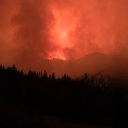

In [8]:
i = 0
print(y_true[i])
revert(X[i])

tensor([-1567.9559], device='cuda:0') tensor(0.0621, device='cuda:0')


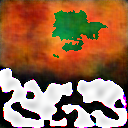

In [9]:
import torch.nn.functional as F
print(y_fake[i], F.l1_loss(R[i], X[i]))
revert(R[i])

In [15]:
lambda_ = [0,1,1]
a = F.l1_loss(R, X, reduction="mean")
if trainer.encoder is not None:
    b = F.mse_loss(gd1,ed1)
    print(a, b)
else:
    b = 0
print(y_true)
print(y_fake.flatten())
a*lambda_[0] + y_fake*lambda_[1] + b*lambda_[2]

tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])
tensor([-1567.9559, -1567.9559, -1567.9559, -1567.9559, -1567.9559, -1567.9559,
        -1567.9559, -1567.9559, -1567.9559, -1567.9559, -1567.9559, -1567.9559],
       device='cuda:0')


tensor([[-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559],
        [-1567.9559]], device='cuda:0')

In [14]:
epoch = 20
torch.save(trainer.generator, f"Models/genproject_e{epoch}.pt")
torch.save(trainer.discriminator, f"Models/dscproject_e{epoch}.pt")
torch.save(trainer.encoder, f'Models/brcproject_e{epoch}.pt')

# For usage with pre-trained models

In [ ]:
t_epoch = 9
gen_path = pathlib.Path(f'genproject_e{t_epoch}.pt').resolve()
dsc_path = pathlib.Path(f'dscproject_e{t_epoch}.pt').resolve()
brc_path = pathlib.Path(f'brcproject_e{t_epoch}.pt').resolve()
gen = torch.load(gen_path, map_location=device)
dsc = torch.load(dsc_path, map_location=device)
brc = torch.load(brc_path, map_location=device)
pretrain = train.GANProject(load_unet=gen, load_cnn=dsc, load_branch=brc, img_size=128, debug=False)

In [ ]:
X, y_true = next(iter(wf1TsFireLd))
X = X.to(device)
revert = v2.ToPILImage()
with torch.no_grad():
    R,_,_,_,_ = pretrain.generator(X)
    R = R.to(device)
    y_fake = pretrain.discriminator(R)

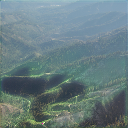

In [ ]:
i = 5
print(y_true[i])
revert(X[i])

In [ ]:
print(y_fake[i])
revert(R[i])

In [ ]:
import torch.nn.functional as F
F.l1_loss(R[i], X[i])